In [1]:
import requests as req
import pandas as pd
import numpy as np
import matplotlib as mat
from matplotlib import pyplot as plt

# Анализ данных

Гипотезы и цели:

1. На сколько треки популярные во всём мире, популярны в разных странах
2. Какое распределение предпочитаемых жанров среди стран
3. Выяснить долю и популярность локальных исполнителей
4. Разделить страны на кластеры по предпочтениям жанров и атрибутов музыки  

Для удобства в первую очередь проверю все гипотезы на одном чарте, в дальнейшем проверю на остальных

In [12]:
week_charts = pd.read_csv('data_sets\week_charts_features.csv', index_col=0)

### Дообработка данных (если нужна позиция в чарте)

Поздно понял что место трека в чарте полезная информация

In [5]:
position = np.arange(1, 51)
countrs = week_charts.country.unique()
iterabli = [countrs, position]
idx = pd.MultiIndex.from_product(iterabli, names=['country', 'place'])

In [6]:
week_place = week_charts.set_index(idx) \
            .drop('country', axis=1) \
            .reset_index()

ValueError: Length mismatch: Expected 6166 rows, received array of length 2650

In [7]:
week_place.head(4)

NameError: name 'week_place' is not defined

## 1. Насколько чарты стран схожи с глобальным чартом

Формирую глобальный и локальные чарты

In [5]:
global_chart = week_place[week_place.country == 'во всем мире'][['place', 'name']]
global_chart.head(3)

,place,name
0,1,Heat Waves
1,2,STAY (with Justin Bieber)
2,3,Enemy (with JID) - from the series Arcane Leag...


In [6]:
country_charts = week_place[week_place.country != "во всем мире"][['country', 'place', 'name']]
country_charts.head(3)

,country,place,name
50,Австралия,1,Heat Waves
51,Австралия,2,STAY (with Justin Bieber)
52,Австралия,3,Cold Heart - PNAU Remix


Фрейм с треками и их позициями, которые есть в глобальном и локальных чартах

In [7]:
similarity = pd.merge(country_charts, global_chart, on='name', how='inner', suffixes=['_in_global', '_in_local'])
similarity.head(3)

,country,place_in_global,name,place_in_local
0,Австралия,1,Heat Waves,1
1,Австрия,1,Heat Waves,1
2,Бельгия,3,Heat Waves,1


Добавил три метрики:  
Средняя позиция треков глобольного чарта в локальном  

Стандартное отклонение разницы позиции трека в глобальном и локальных чартах  
<!-- Иными словами - на сколько в среднем позиция трека в локальном чарте отличается от позиции в глобальном -->
  
Станартная ошибка среднего

Мысли:  
Позиция в чарте - ранговая переменная, не все "классические" методы подойдут для анализа  
Если формировать новые выборки, прошлые и новые данные будут зависимыми переменными  

In [43]:
result = similarity.copy()
result['diff'] = result.place_in_local - result.place_in_global
result = result.groupby('country') \
                .agg(
                    amount=('name', 'count'),
                    average_place_in_local=('place_in_local', lambda x: np.around(np.mean(x), 2)),
                    std=('diff', 'std'),
                    se=('diff', lambda x: x.std() / 50 ** 0.5)
                )
result = result.sort_values('amount', ascending=0)

In [45]:
result

,amount,average_place_in_local,std,se
country,,,,
ОАЭ,35,22.80,7.476911,1.057395
Канада,34,22.03,13.569685,1.919043
Австралия,31,21.84,10.281207,1.453982
Швейцария,27,17.59,11.830835,1.673133
США,27,21.04,13.726262,1.941187
Ирландия,26,19.08,12.679299,1.793124
Австрия,25,18.56,10.388776,1.469195
Чехия,24,17.83,11.813696,1.670709
Словакия,24,17.62,13.142199,1.858588


<AxesSubplot:>

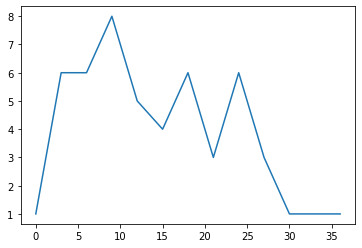

In [15]:
result.amount.apply(lambda x: 3 * round(x/3)).value_counts().sort_index().plot()

<AxesSubplot:>

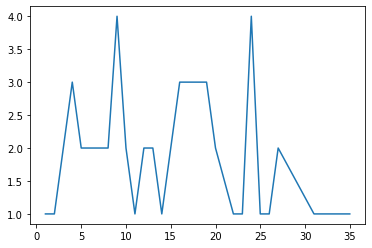

In [13]:
result.amount.value_counts().sort_index().plot()

## 2. Предпочитаемые жанры среди стран

In [15]:
country_charts = week_charts[week_charts.country != 'во всем мире']

In [23]:
country_charts.genre.unique()

539

In [21]:
rus = country_charts.groupby('country').get_group('Россия')
rus.genre.value_counts()

russian hip hop          34
russian drain            13
russian trap              8
russian alt pop           7
russian pop               6
russian drill             3
russian indie rock        2
russian hyperpop          2
russian emo rap           2
kazakh pop                1
russian viral pop         1
central asian hip hop     1
kazakh hip hop            1
modern rock               1
weirdcore                 1
russian dance pop         1
russian pop punk          1
russian punk              1
russian punk rock         1
russian gangster rap      1
russian grime             1
drift phonk               1
otacore                   1
fnaf                      1
rock                      1
kavkaz                    1
russian indie             1
russian dance             1
pop                       1
alt z                     1
russian rock              1
Name: genre, dtype: int64

## Исполнители попавшие в наибольшее число чартов 

In [10]:
week_place.groupby('artist') \
    .agg({'artist':'count', 'place':np.mean}) \
    .rename(columns={'artist':'times_in_charts'}) \
    .sort_values('times_in_charts', ascending=False)

,times_in_charts,place
artist,,
Bad Bunny,75,28.026667
Ed Sheeran,64,23.578125
Lil Nas X,54,22.203704
Imagine Dragons,42,20.000000
Glass Animals,38,11.736842
...,...,...
Kaan Boşnak,1,26.000000
Kacperczyk,1,27.000000
Kaleb J,1,16.000000
